The `%matplotlib notebook` command is a Jupyter magic command that allows interactive plots to be displayed in a Jupyter notebook. It is used to render plots in the notebook itself. However, it seems that you are working in Visual Studio Code, which is an IDE and not a Jupyter notebook. Therefore, `%matplotlib notebook` may not work as expected. Instead, you can use `%matplotlib inline` to display plots inline in the output cell of the VS Code editor.

In [1]:
%matplotlib inline

The audio is not stereo.
The two WAV files have different sample rates fs1 = 44100 and fs2 = 48000.
The length of audio1 is 480000 and the length of audio2 is 1917600.
The lag is 1341914 and the adjusted lag is 861914


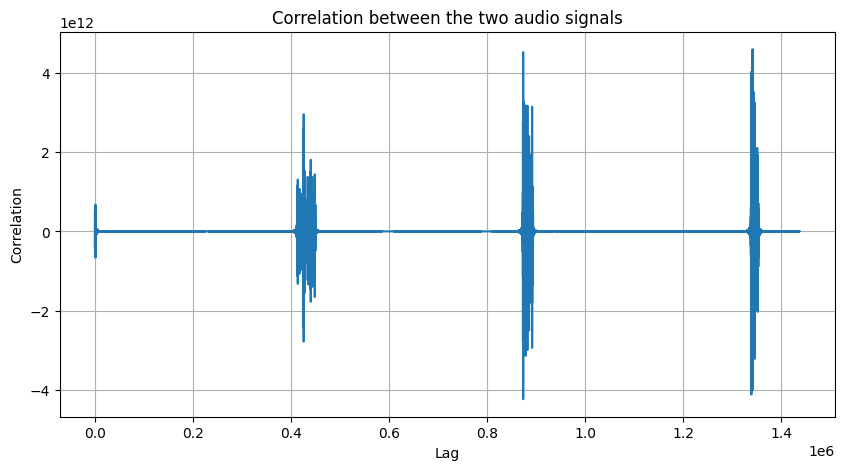

In [2]:
import numpy as np
from scipy.io.wavfile import read, write
from scipy.signal import correlate, resample
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
import math


# Load the two WAV files
fs1, raw_audio1 = read('chirp_stereo.wav')
#fs2, raw_audio2 = read('/mnt/hgfs/share/demo/nrf53audiodk_cis_c2_close_stream1.wav')
fs2, raw_audio2 = read('/mnt/hgfs/share/demo/nrf53audiodk_cis_c3_medium_stream1.wav')

#fs2, raw_audio2 = read('/mnt/hgfs/share/demo/nrf53audiodk_cis_c4_far_stream1.wav')
#fs2, raw_audio2 = read('/mnt/hgfs/share/demo/nrf53audiodk_cis_c6_far_devices_far_stream1.wav')

# Check if the audio is stereo
if len(raw_audio1.shape) == 2 and raw_audio1.shape[1] == 2:
    raw_audio1 = raw_audio1[:, 0]
   # right_channel = raw_audio1[:, 1]
else:
    print("The audio is not stereo.")

# Check if the audio is stereo
if len(raw_audio2.shape) == 2 and raw_audio2.shape[1] == 2:
    raw_audio2 = raw_audio2[:, 0]
   # right_channel = raw_audio2[:, 1]
else:
    print("The audio is not stereo.")

# Ensure the sample rates are the same
if fs1 != fs2:
    print(f"The two WAV files have different sample rates fs1 = {fs1} and fs2 = {fs2}.")

if fs1 > fs2:
    # Step 2: Resample the audio
    num_samples = int(len(raw_audio2) * fs1 / fs2)
    audio2 = resample(raw_audio2, num_samples)
    audio1 = raw_audio1
    fs2 = fs1
elif fs1 < fs2:
    # Step 2: Resample the audio
    num_samples = int(len(raw_audio1) * fs2 / fs1)
    audio1 = resample(raw_audio1, num_samples)
    audio2 = raw_audio2
    fs1 = fs2
print(f"The length of audio1 is {len(audio1)} and the length of audio2 is {len(audio2)}.")

# Step 3: Normalize the audio
# Find the correlation between the two signals
# This will give an array that indicates for each lag value how well the signals match
corr = correlate(audio2, audio1, 'valid')

# Find the maximum correlation index
# This index indicates the best alignment (lag) of the two signals
lag = np.argmax(corr)
print(f"The lag is {lag} and the adjusted lag is {lag-len(audio1)}")

# plot the correlation
plt.figure(figsize=(10, 5))
plt.plot(corr)
plt.title("Correlation between the two audio signals")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.grid()
plt.show()


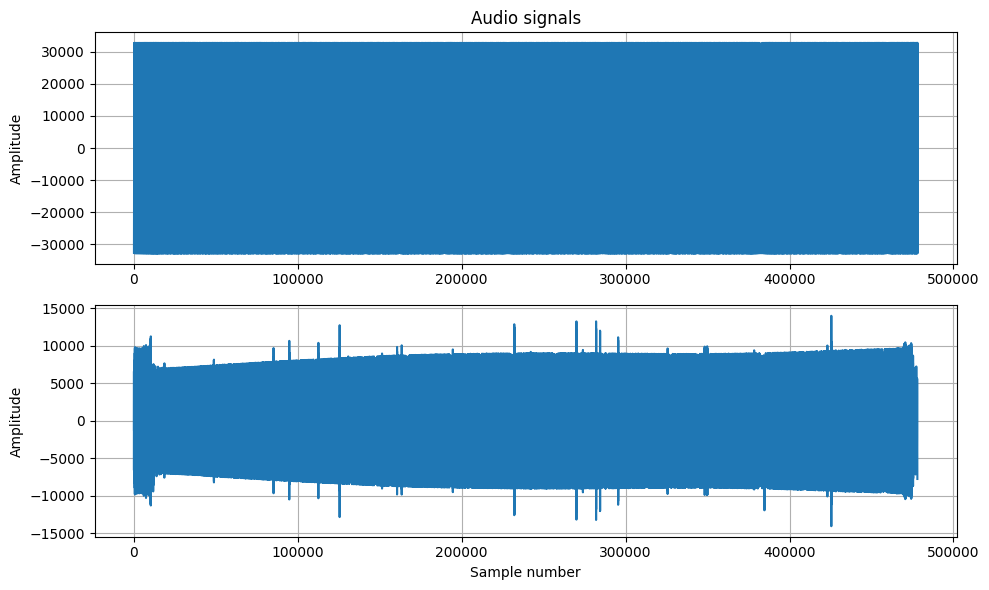

In [3]:



# If audio1 starts before audio2, then lag will be positive
if lag > 0:
    #audio2 = audio2[(lag-int(1.125*len(audio1))):]
    audio2 = audio2[(lag):]
    audio2 = audio2[:len(audio1)]

# If audio2 starts before audio1, then lag will be negative
elif lag < 0:
    audio2 = audio2[-lag:]
    audio1 = audio1[:len(raw_audio2)]

# Trim a fixed number of samples from start and end (e.g., 1000 samples)
trim_samples = 1000
audio1 = audio1[trim_samples:-trim_samples]
audio2 = audio2[trim_samples:-trim_samples]

# Now audio1 and audio2 are aligned and have the same length
# Save them if needed
# write('aligned_file1.wav', fs1, audio1)
# write('aligned_file2.wav', fs2, audio2)

# create a plot of the two signals
# create a plot of the two signals
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax1.plot(audio1)
ax2.plot(audio2)
ax1.set_ylabel('Amplitude')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Sample number')
ax1.set_title('Audio signals')
ax1.grid(True)
ax2.grid(True)
fig.tight_layout()
plt.show()



In [4]:
len(audio2)

478000

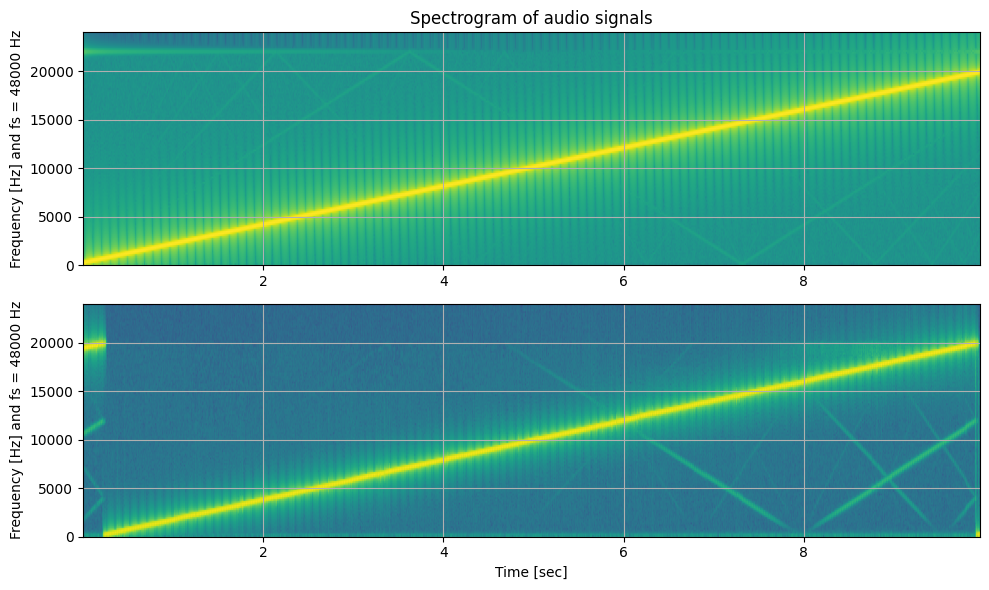

In [5]:
# plot the spectrogram of the two signals
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax1.specgram(audio1, Fs=fs1)
ax2.specgram(audio2, Fs=fs2)
ax1.set_ylabel(f'Frequency [Hz] and fs = {fs1} Hz')
ax2.set_ylabel(f'Frequency [Hz] and fs = {fs2} Hz')
ax2.set_xlabel('Time [sec]')
ax1.set_title('Spectrogram of audio signals')
ax1.grid(True)
ax2.grid(True)
fig.tight_layout()
plt.show()


In [6]:

def mse(signal1, signal2):
    return np.mean((signal1 - signal2) ** 2)

def mae(signal1, signal2):
    return np.mean(np.abs(signal1 - signal2))


print(f"Mean Square Error: {mse(audio1, audio2)}")
print(f"Mean Absolute Error: {mae(audio1, audio2)}")

Mean Square Error: 539483598.7263308
Mean Absolute Error: 20681.405334806263


In [2]:
import pandas as pd

file_list = [
    '/mnt/hgfs/share/demo/nrf53audiodk_cis_c2_close.csv',
    '/mnt/hgfs/share/demo/nrf53audiodk_cis_c3_medium.csv',
    '/mnt/hgfs/share/demo/nrf53audiodk_cis_c4_far.csv',
    '/mnt/hgfs/share/demo/nrf53audiodk_cis_c6_far_devices_far.csv'
]

dataframes = []  # list to store individual dataframes

# loop through the files and read them in with pandas
for file in file_list:
    data = pd.read_csv(file)
    # add a column to the dataframe with the filename
    data['filename'] = file
    dataframes.append(data)

# Concatenate all the dataframes in the list into a master dataframe
master_data = pd.concat(dataframes, ignore_index=True)

print(master_data)

     Event  Mode  Stream Event Type  Frame #     Severity  \
0        1   NaN       1  Bluetooth      336  Information   
1        2   NaN       2  Bluetooth      797  Information   
2        3   NaN       1      Codec  14,534   Information   
3        4   NaN       2      Codec  14,537   Information   
4        5   NaN       1  Bluetooth  16,027       Warning   
..     ...   ...     ...        ...      ...          ...   
922    103   NaN       4  Bluetooth  43,492       Warning   
923    104   NaN       4  Bluetooth  43,554       Warning   
924    105   NaN       4  Bluetooth  43,704       Warning   
925    106   NaN       4  Bluetooth  43,764       Warning   
926    107   NaN       4  Bluetooth  43,873       Warning   

                                           Description  \
0    LE Audio connection established between device...   
1    LE Audio connection established between device...   
2    Codec: LC3 Sample Rate: 48000, Bits Per Sample...   
3    Codec: LC3 Sample Rate: 48000,